In [2]:
import torchphysics as tp
import numpy as np
import torch
from matplotlib import pyplot as plt

# Physics Informed Neural Networks (PINNs) in TorchPhysics
In this tutorial we present a first basic example of solving a simple ODE with an initial condition in TorchPhysics using a PINN approach.
You will also learn about the different components of this library and main steps for finding a neural network that approximates the solution of a PDE.

We consider the simple ODE:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t) &= u(t) &&\text{ on the interval } (0, 2), \\
u(t) &= u_0 &&\text{ for } t\in \{ 0\}.
\end{cases}
$$
In the following we want to learn the solution function $u(t) = u_0 e^t$, where we set the initial value to $u_0=2$.

In [3]:
u_0 = 2 # initial value

## Recall PINNs
The goal is to find a neural network $u_\theta:[0, 2]\to \mathbb{R}$, which approximately satisfies the two conditions of the ODE problem above, where $\theta$ are the trainable parameters of the neural network.
Let us shortly recall the main idea behind PINNs.

The residuals are denoted by
$$
\begin{align}
&\text{1) Residual of the ODE condition: }      &&R_1(u, t) := \frac{\partial^2}{\partial t^2} u(t) - u(t) &&&\text{ for } t\in (0,2),\\
&\text{2) Residual of the initial condition: }  &&R_2(u, t) := u(t) - u_0 &&& \text{ for } t\in \{0\}.
\end{align}
$$
Continuing with the PINN approach, points are sampled in the domains corresponding to each condition. In our example:
$$
\begin{align}
&\text{1) } &&\big(t_i^{(1)} \big)_i &&&\in (0, 2),\\
&\text{2) } &&\big(t_j^{(2)} \big)_j        &&&\in \{0\}.
\end{align}
$$
Then, the network $u_\theta$ is trained by solving the following minimization problem
$$
\begin{align}
\min_\theta \sum_{i} \big\vert R_1(u_\theta, t_i^{(1)}) \big \vert^2 + \sum_j \big\vert R_2(u_\theta, t_j^{(2)}) \big \vert^2,
\end{align}
$$
that is, the residuals are minimized with respect to the $l_2$-norm.

## Translating the PDE Problem into the Language of TorchPhysics
Translating the PDE problem into the framework of TorchPhysics works in a convenient and intuitive way, as the notation is close to the mathematical formulation. The general procedure can be devided into five steps. Also when solving other problems with TorchPhysics, such as parameter identification or variational problems, the same steps can be applied, see also the further [tutorials](https://boschresearch.github.io/torchphysics/tutorial/tutorial_start.html) or [examples](https://boschresearch.github.io/torchphysics/examples.html).

### Step 1: Specify spaces and domains
The domain $I=(0, 2)$ is a subset of the space $\mathbb{R}$, whereas the range space of the solution function $u$ is $\mathbb{R}$. First, we need to let TorchPhysics know which spaces and domains we are dealing with and how variables/elements within these spaces are denoted by.
This is realized by generating objects of TorchPhysics' Space and Domain classes in "tp.spaces" and "tp.domains", respectively.
Some simple domains are already predefined, which will be sufficient for this tutorial. We need an interval domain, which is an open interval by default. For creating complexer domains please have a look at the [domain-tutorial](https://boschresearch.github.io/torchphysics/tutorial/tutorial_domain_basics.html).

In [4]:
# Input and output spaces
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')

# Domain
I  = tp.domains.Interval(space=T, lower_bound=0, upper_bound=2)

### Step 2: Define point samplers for different subsets of [0, 2]
As mentioned in the PINN recall, it will be necessary to sample points in different subsets of the full domain $I$. TorchPhysics provides this functionality by sampler classes in "tp.samplers". For simplicity, we consider only Random Uniform Samplers for the subdomains. However, there are many more possibilities to sample points in TorchPhysics, see also [sampler-tutorial](https://boschresearch.github.io/torchphysics/tutorial/sampler_tutorial.html).

The most important inputs of a sampler constructor are the "domain" from which points will be sampled, as well as the "number of points" drawn every time the sampler is called. It is reasonable to create different sampler objects for the different conditions of the pde problem, simply because the subdomains differ.

The ODE condition 1) should hold for points in the domain $I=(0, 2)$. We have defined this domain already in Step 1, so that we can define a point sampler:

In [5]:
sampler_ode_condition = tp.samplers.RandomUniformSampler(domain=I, n_points=150)

Next, let us define samplers for the initial condition. This condition should hold on the domain $\{0\}$, which is the left boundary of the interval $I=(0,2)$. All tp.domains.Interval objects have the attribute "left_boundary", an instance of TorchPhysics BoundaryDomain class, a subclass of the Domain class. This allows to construct a sampler for this initial condition.

In [6]:
domain_initial_condition = I.boundary_left
sampler_initial_condition = tp.samplers.RandomUniformSampler(domain_initial_condition, 50)

For more detailed information on the functionality of TorchPysics samplers, please have a look at the further [tutorials](https://torchphysics.de/tutorial), [examples](https://boschresearch.github.io/torchphysics/examples.html) or the in-depth [sampler-tutorial](https://boschresearch.github.io/torchphysics/tutorial/sampler_tutorial.html).

### Step 3: Define residual functions
As mentioned in the PINNs Recall, we are looking for a neural network $u_\theta$ for which all of the residual functions $R_1$ and $R_2$ vanish.

Let us have a look at $R_1$, the residual for the ODE condition, the way it is defined in the PINNs recall above. The inputs of $R_1$ are the coordinate $t\in(0,2)$, but also $u_\theta$, which is itself a function of $t$. In TorchPhysics, the evaluation of the network $u_\theta$ at $t$ is done before evaluating the residual functions. This means that from now on we consider $R_1$ as well as the other residuals to be functions, whose inputs are tuples $(u, t)$, where $u:=u_\theta(t)$.

More precisely, $u$ will be a torch.tensor of shape (n_points, 1) and $t$ of shape (n_points, 1), where n_points is the number of triples $(u,t)$ for which the residual should be computed.

For the residual $R_1$ it is required to compute the first derivative (gradient) of $u$ with respect to $t$. This differential operator, among others - see the [utils-tutorial](https://boschresearch.github.io/torchphysics/tutorial/differentialoperators.html), are pre-implemented and can be found in "tp.utils". The intern computation is build upon torch's autograd functionality.

In [7]:
def residual_ode_condition(u, t):
    return u - tp.utils.grad(u, t)

For the computation of the residual $R_2$ of the initial condition, the coordinate $t\in \{0\}$ is not required, since $u$ is already the evaluation of the network at these sampling points. Therefore, we can conveniently omit them as input parameters.

In [8]:
def residual_initial_condition(u):
    return u - u_0

### Step 4: Define Neural Network
At this point, let us define the model $u_\theta:[0,2]\to \mathbb{R}$. This task is handled by the TorchPhysics Model class, which is contained in "tp.models". It inherits from the torch.nn.Module class from Pytorch, which means that building own models can be achieved in a very similar way, see [model-tutorial](https://boschresearch.github.io/torchphysics/tutorial/model_creation.html).
There are also a bunch of predefined neural networks or single layers available. In this tutorial we consider a very simple neural network, a FNO consisting of four hidden layers with $80, 50, 50$ and $50$ neurons, respectively.:

In [9]:
model = tp.models.FCN(input_space=T, output_space=U, hidden = (50,50,50))

### Step 5: Create TorchPhysics Conditions
Let us sum up what we have done so far: For the ODE and initial condition, we constructed samplers and residuals on the corresponding domains.
Moreover, we have defined a neural network which will later be trained to fulfull each of these conditions.

As a final step, we collect these constructions for each condition in an object of the TorchPhysics Condition class, contained in "tp.conditions".
Since we are interested in applying a PINN approach, we create objects of the subclass PINNCondition, which automatically contains the information that the residuals should be minimized in the squared $l_2$-norm, see again the PINN Recall. For other TorchPhysics Conditions one may need to specify which norm should be taken of the residuals, see [condition-tutorial](https://boschresearch.github.io/torchphysics/tutorial/condition_tutorial.html) for further information.

In [10]:
ode_condition      = tp.conditions.PINNCondition(module     =model,
                                                 sampler    =sampler_ode_condition,
                                                 residual_fn=residual_ode_condition)

initial_condition  = tp.conditions.PINNCondition(module     =model,
                                                 sampler    =sampler_initial_condition,
                                                 residual_fn=residual_initial_condition)

It is to be noted that TorchPhysics' Condition class is a subclass of the torch.nn.Module class and its forward() method returns the current loss of the respective condition.
For example, calling forward() of the ode_condition at points $(t_i)_i$ in $I=(0,2)$ will return
$$
\begin{align}
\sum_i \big \vert R_1(u_\theta, t_i) \big \vert^2,
\end{align}
$$
where $R_1$ is the residual function for the ODE condition defined in the PINN recall and $u_\theta$ is the model defined in Step 4.

The reason that also the model is required for initializing a Condition object is, that it could be desireable in some [cases](https://github.com/boschresearch/torchphysics/blob/main/examples/pinn/interface-jump.ipynb) to train different networks for different conditions of the PDE problem.

## Training based on Pytorch Lightning
In order to train a model, TorchPhysics makes use of the Pytorch Lightning library, which hence must be imported. Further, we import "os" so that GPUs can be used for the calculations.

In [11]:
import pytorch_lightning as pl
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" if torch.cuda.is_available() else "0"

print ("GPU available: " + str(torch.cuda.is_available()))

GPU available: False


For the training process, i.e. the minimization of the loss function introduced in the PINN recall, TorchPhysics provides the Solver class. It inherits from the pl.LightningModule class and is compatible with the TorchPhysics library. The constructor requires a list of TorchPhysics Conditions, whose parameters should be optimized during the training.

In [12]:
training_conditions = [ode_condition, initial_condition]

By default, the Solver uses the Adam Optimizer from Pytorch with learning rate $lr=0.001$ for optimizing the training_conditions. If a different optimizer or choice of its arguments shall be used, one can collect these information in an object of TorchPhysics' OptimizerSetting class.

In [13]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)

Finally, we are able to create the Solver object, a Pytorch Lightning Module.

In [14]:
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

Now, as usual, the training is done with a Pytorch Lightning Trainer object and its fit() method.

In [15]:
# Start the training
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

trainer = pl.Trainer(devices=1, accelerator=accelerator, # what to use to solve problem and how many devices
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=1000, # number of training steps
                     logger=False,
                     enable_checkpointing=False)

trainer.fit(solver) # start training

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | train_conditions | ModuleList | 5.3 K  | train
1 | val_conditions   | ModuleList | 0      | train
--------------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


You can also re-run the last three blocks with a smaller learning rate to further decrease the loss.

Of course, the state dictionary of the model can be saved in the common way: torch.save(model.state_dict(), 'sd')

## Visualization
Torchphysics provides built-in functionalities for visualizing the outcome of the neural network. We use the plot() function from "tp.utils", which is built on the Matplotlib library. The most important inputs are:
1) model: The neural network whose output shall be visualized.
2) plot_function: Will be applied to the model's output before visualization. E.g. if the output was two-dimensional, the plot_function $u\mapsto u[:, 0]$ could be used for showing only its first coordinate.
3) point_sampler: A sampler creating points the neural network will be evaluated at for creating the plot. More information is provided in the further [tutorials](https://torchphysics.de/tutorial) or the in-depth [plot-tutorial](https://boschresearch.github.io/torchphysics/tutorial/plotting.html).

Let us start with the sampler. The samplers we have seen so far (RandomUniformSampler, GridSampler) plot either on the interior or the boundary of their domain.
However, it is desirable to consider both the interior and the boundary points in the visualization. For this, one can use a PlotSampler, which is desined for harmonizing with plotting duties.

In [16]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=I, n_points=100)

In our case, the model's output is a scalar and we do not want to modify it before plotting. Hence, plot_function should be the identity mapping, in Python syntax: lambda u: u.

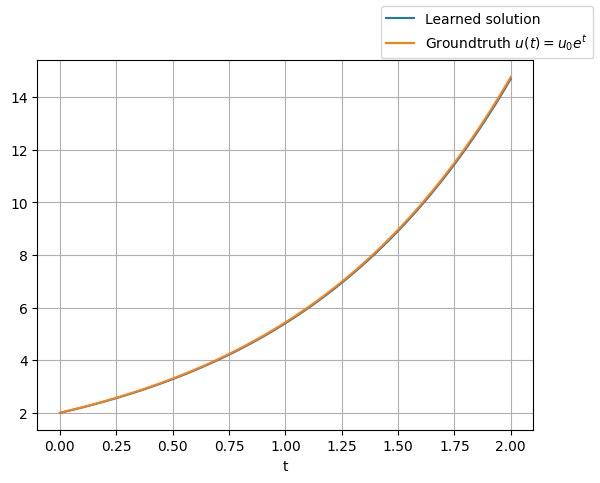

In [17]:
fig = tp.utils.plot(model=model, plot_function=lambda u : u, point_sampler=plot_sampler, label='Learned solution')
# plot also groundtruth
sampling_points = np.linspace(0, 2, 100)
plt.plot(sampling_points, 2*np.exp(sampling_points), label=f'Groundtruth $u(t) = u_0e^t$')
fig.legend()
plt.show()